In [1]:
# импорты и первичные настройки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error
from scipy.spatial.distance import cosine
from scipy.sparse import csr_matrix
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

# Установка стиля для лучшей визуализации
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

RANDOM_SEED = 13
np.random.seed(RANDOM_SEED)

# Этап 1: знакомство с данными и EDA (Exploratory Data Analysis)


## 1. Загрузите данные: ratings.csv, books.csv, tags.csv, book_tags.csv.


In [2]:
# Загрузка файлов данных
ratings_df = pd.read_csv('data/books/ratings.csv')
books_df = pd.read_csv('data/books/books.csv')
tags_df = pd.read_csv('data/books/tags.csv')
book_tags_df = pd.read_csv('data/books/book_tags.csv')

## 2. Проведите разведочный анализ:
    - Распределение оценок. Есть ли смещение в сторону высоких оценок?
    - Анализ активности пользователей. Постройте график «Взаимоотношение количества пользователей и количества оценок». Выявите активных пользователей и пользователей с малым количеством взаимодействий (проблема холодного старта).
    - Анализ популярности книг. Постройте график «Количество книг vs количество оценок». Выявите популярные книги и «длинный хвост».
    - Визуализируйте самые частые теги для книг (на основе book_tags.csv).

Для начала сделаем обзор датасетов, чтобы понять их структуру

In [3]:
# Вывод основной информации о каждом датасете
print("Форма датасета оценок:", ratings_df.shape)
print("Информация о датасете оценок:")
print(ratings_df.info())
print("\nПервые несколько строк оценок:")
print(ratings_df.head())

Форма датасета оценок: (5976479, 3)
Информация о датасете оценок:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5976479 entries, 0 to 5976478
Data columns (total 3 columns):
 #   Column   Dtype
---  ------   -----
 0   user_id  int64
 1   book_id  int64
 2   rating   int64
dtypes: int64(3)
memory usage: 136.8 MB
None

Первые несколько строк оценок:
   user_id  book_id  rating
0        1      258       5
1        2     4081       4
2        2      260       5
3        2     9296       5
4        2     2318       3


In [4]:
print("Форма датасета книг:", books_df.shape)
print("Информация о датасете книг:")
print(books_df.info())
print("\nПервые несколько строк книг:")
print(books_df.head())

Форма датасета книг: (10000, 23)
Информация о датасете книг:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   book_id                    10000 non-null  int64  
 1   goodreads_book_id          10000 non-null  int64  
 2   best_book_id               10000 non-null  int64  
 3   work_id                    10000 non-null  int64  
 4   books_count                10000 non-null  int64  
 5   isbn                       9300 non-null   object 
 6   isbn13                     9415 non-null   float64
 7   authors                    10000 non-null  object 
 8   original_publication_year  9979 non-null   float64
 9   original_title             9415 non-null   object 
 10  title                      10000 non-null  object 
 11  language_code              8916 non-null   object 
 12  average_rating             10000 non-null 

In [5]:
print("Форма датасета тегов:", tags_df.shape)
print("Информация о датасете тегов:")
print(tags_df.info())
print("\nПервые несколько строк тегов:")
print(tags_df.head())

Форма датасета тегов: (34252, 2)
Информация о датасете тегов:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34252 entries, 0 to 34251
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tag_id    34252 non-null  int64 
 1   tag_name  34252 non-null  object
dtypes: int64(1), object(1)
memory usage: 535.3+ KB
None

Первые несколько строк тегов:
   tag_id tag_name
0       0        -
1       1     --1-
2       2    --10-
3       3    --12-
4       4   --122-


In [6]:
print("Форма датасета связей книг и тегов:", book_tags_df.shape)
print("Информация о датасете связей книг и тегов:")
print(book_tags_df.info())
print("\nПервые несколько строк связей книг и тегов:")
print(book_tags_df.head())

Форма датасета связей книг и тегов: (999912, 3)
Информация о датасете связей книг и тегов:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999912 entries, 0 to 999911
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   goodreads_book_id  999912 non-null  int64
 1   tag_id             999912 non-null  int64
 2   count              999912 non-null  int64
dtypes: int64(3)
memory usage: 22.9 MB
None

Первые несколько строк связей книг и тегов:
   goodreads_book_id  tag_id   count
0                  1   30574  167697
1                  1   11305   37174
2                  1   11557   34173
3                  1    8717   12986
4                  1   33114   12716


### Распределение оценок

Проанализируем распределение оценок, чтобы увидеть, есть ли смещение в сторону высоких оценок.

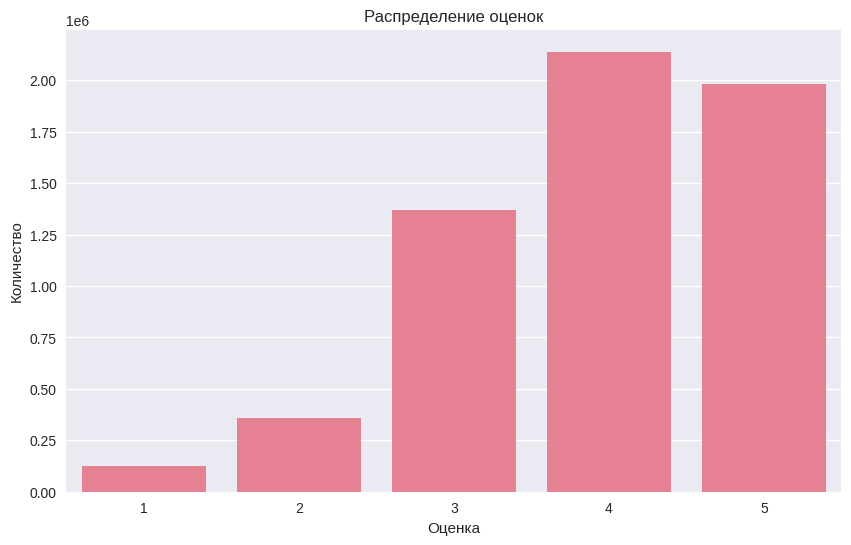

Статистика оценок:
count    5.976479e+06
mean     3.919866e+00
std      9.910868e-01
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

Процентное соотношение каждой оценки:
Оценка 1: 2.08%
Оценка 2: 6.01%
Оценка 3: 22.94%
Оценка 4: 35.79%
Оценка 5: 33.18%


In [7]:
# Распределение оценок
plt.figure(figsize=(10, 6))
sns.countplot(data=ratings_df, x='rating')
plt.title('Распределение оценок')
plt.xlabel('Оценка')
plt.ylabel('Количество')
plt.show()

# Расчет статистики оценок
rating_stats = ratings_df['rating'].describe()
print("Статистика оценок:")
print(rating_stats)

# Расчет процентного соотношения каждой оценки
rating_percentages = ratings_df['rating'].value_counts().sort_index() / len(ratings_df) * 100
print("\nПроцентное соотношение каждой оценки:")
for rating, percentage in rating_percentages.items():
    print(f"Оценка {rating}: {percentage:.2f}%")

Видно, что оценки 1 и 2 имеют в сумме всего около 8% от общего количества оценок.
Можно констатировать, что есть смещение в сторону высоких оценок

### Анализ активности пользователей

Проанализируем активность пользователей, чтобы определить активных пользователей и потенциальную проблему холодного старта.

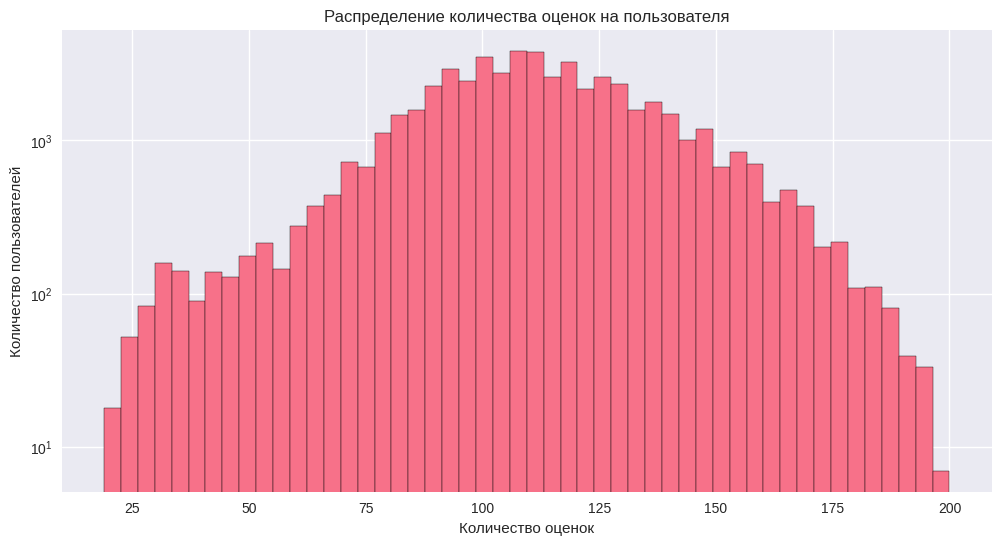

Статистика активности пользователей:
Общее количество пользователей: 53424
Среднее количество оценок на пользователя: 111.87
Медианное количество оценок на пользователя: 111.0
Минимальное количество оценок на пользователя: 19
Максимальное количество оценок на пользователя: 200

Активные пользователи (100+ оценок): 37084 (69.41% всех пользователей)
Пользователи с 30 или менее оценками (потенциальный холодный старт): 190 (0.36% всех пользователей)


In [8]:
# Расчет количества оценок для каждого пользователя
user_ratings_count = ratings_df.groupby('user_id').size().sort_values(ascending=False)

# Построение графика зависимости количества пользователей от количества оценок
plt.figure(figsize=(12, 6))
plt.hist(user_ratings_count.values, bins=50, edgecolor='black')
plt.title('Распределение количества оценок на пользователя')
plt.xlabel('Количество оценок')
plt.ylabel('Количество пользователей')
plt.yscale('log') # Логарифмическая шкала для лучшей визуализации распределения
plt.show()

# Показ статистики об активности пользователей
print("Статистика активности пользователей:")
print(f"Общее количество пользователей: {len(user_ratings_count)}")
print(f"Среднее количество оценок на пользователя: {user_ratings_count.mean():.2f}")
print(f"Медианное количество оценок на пользователя: {user_ratings_count.median()}")
print(f"Минимальное количество оценок на пользователя: {user_ratings_count.min()}")
print(f"Максимальное количество оценок на пользователя: {user_ratings_count.max()}")

# Определение активных пользователей (пользователи с множеством оценок) и неактивных пользователей (проблема холодного старта)
active_users = user_ratings_count[user_ratings_count >= 100]
inactive_users = user_ratings_count[user_ratings_count <= 30]

print(f"\nАктивные пользователи (100+ оценок): {len(active_users)} ({len(active_users)/len(user_ratings_count)*100:.2f}% всех пользователей)")
print(f"Пользователи с 30 или менее оценками (потенциальный холодный старт): {len(inactive_users)} ({len(inactive_users)/len(user_ratings_count)*100:.2f}% всех пользователей)")

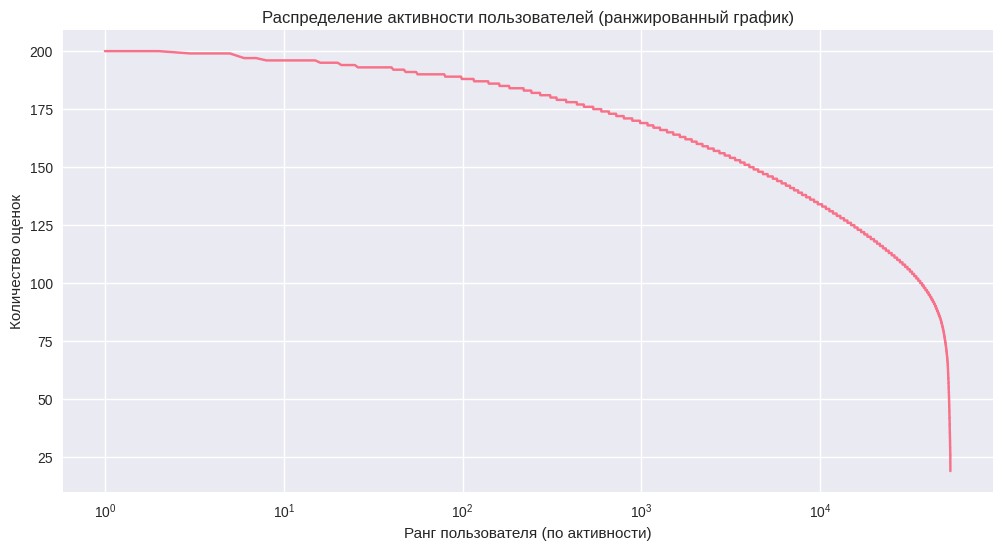

In [9]:
# Построение зависимости количества пользователей от количества оценок (ранжированный график)
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(user_ratings_count) + 1), user_ratings_count.values)
plt.title('Распределение активности пользователей (ранжированный график)')
plt.xlabel('Ранг пользователя (по активности)')
plt.ylabel('Количество оценок')
plt.xscale('log') # Логарифмическая шкала для оси x для лучшей визуализации распределения
plt.grid(True)
plt.show()

### Анализ популярности книг

Проанализируем популярность книг, чтобы определить популярные книги и "длинный хвост".

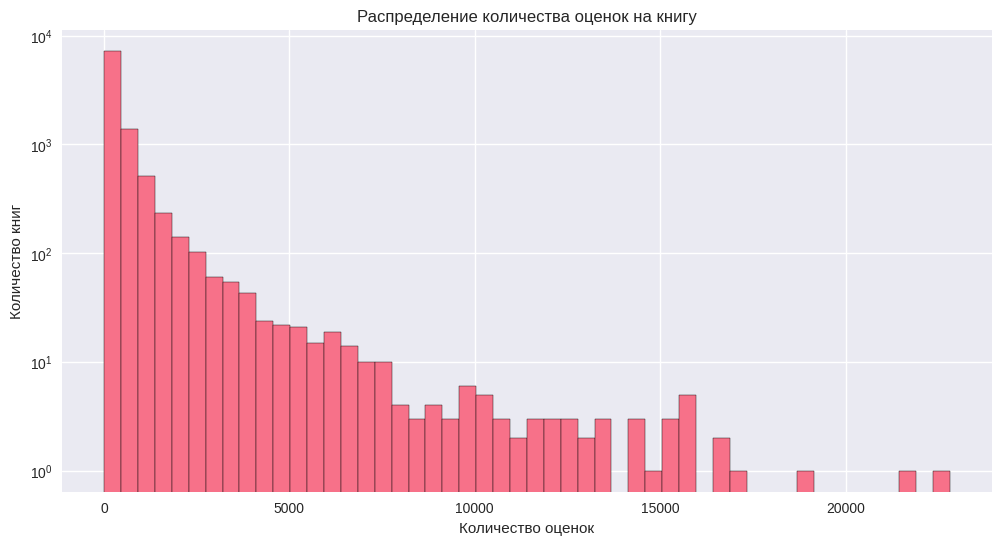

Статистика популярности книг:
Общее количество книг: 10000
Среднее количество оценок на книгу: 597.65
Медианное количество оценок на книгу: 248.0
Минимальное количество оценок на книгу: 8
Максимальное количество оценок на книгу: 22806

Популярные книги (5000+ оценок): 153 (1.53% всех книг)
Книги с 500 или менее оценками (длинный хвост): 7480 (74.80% всех книг)


In [10]:
# Расчет количества оценок для каждой книги
book_ratings_count = ratings_df.groupby('book_id').size().sort_values(ascending=False)

# Построение графика зависимости количества книг от количества оценок
plt.figure(figsize=(12, 6))
plt.hist(book_ratings_count.values, bins=50, edgecolor='black')
plt.title('Распределение количества оценок на книгу')
plt.xlabel('Количество оценок')
plt.ylabel('Количество книг')
plt.yscale('log')  # Логарифмическая шкала для лучшей визуализации распределения
plt.show()

# Показ статистики о популярности книг
print("Статистика популярности книг:")
print(f"Общее количество книг: {len(book_ratings_count)}")
print(f"Среднее количество оценок на книгу: {book_ratings_count.mean():.2f}")
print(f"Медианное количество оценок на книгу: {book_ratings_count.median()}")
print(f"Минимальное количество оценок на книгу: {book_ratings_count.min()}")
print(f"Максимальное количество оценок на книгу: {book_ratings_count.max()}")

# Определение популярных книг (книги с множеством оценок)
min_ratings_threshold = 500
popular_books = book_ratings_count[book_ratings_count >= 5000]
unpopular_books = book_ratings_count[book_ratings_count <= min_ratings_threshold]

print(f"\nПопулярные книги (5000+ оценок): {len(popular_books)} ({len(popular_books)/len(book_ratings_count)*100:.2f}% всех книг)")
print(f"Книги с {min_ratings_threshold} или менее оценками (длинный хвост): {len(unpopular_books)} ({len(unpopular_books)/len(book_ratings_count)*100:.2f}% всех книг)")

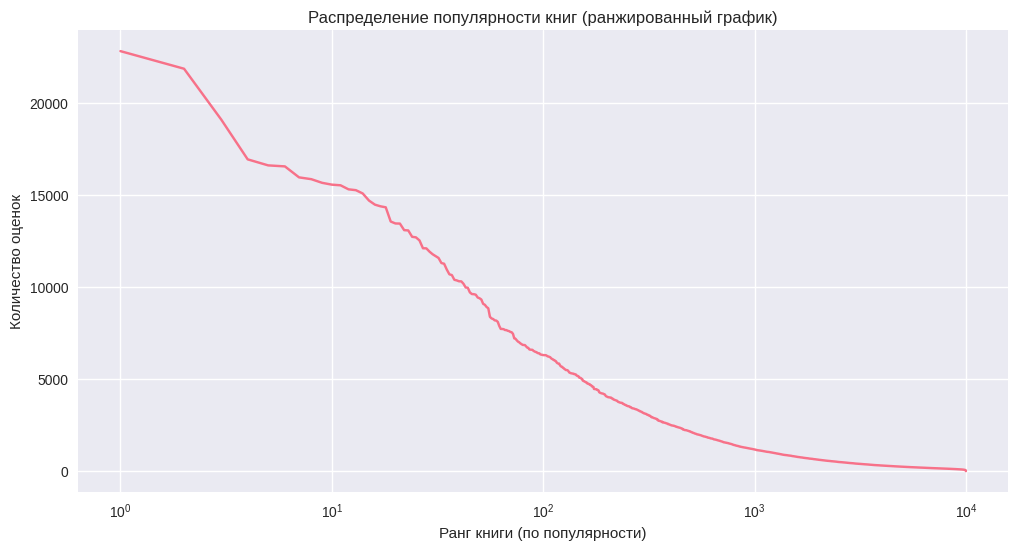


10 самых популярных книг по количеству оценок:
1. ID книги: 1, Название: The Hunger Games (The Hunger Games, #1), Оценок: 22806
2. ID книги: 2, Название: Harry Potter and the Sorcerer's Stone (Harry Potter, #1), Оценок: 21850
3. ID книги: 4, Название: To Kill a Mockingbird, Оценок: 19088
4. ID книги: 3, Название: Twilight (Twilight, #1), Оценок: 16931
5. ID книги: 5, Название: The Great Gatsby, Оценок: 16604
6. ID книги: 17, Название: Catching Fire (The Hunger Games, #2), Оценок: 16549
7. ID книги: 20, Название: Mockingjay (The Hunger Games, #3), Оценок: 15953
8. ID книги: 18, Название: Harry Potter and the Prisoner of Azkaban (Harry Potter, #3), Оценок: 15855
9. ID книги: 23, Название: Harry Potter and the Chamber of Secrets (Harry Potter, #2), Оценок: 15657
10. ID книги: 7, Название: The Hobbit, Оценок: 15558


In [11]:
# Построение зависимости количества книг от количества оценок (ранжированный график)
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(book_ratings_count) + 1), book_ratings_count.values)
plt.title('Распределение популярности книг (ранжированный график)')
plt.xlabel('Ранг книги (по популярности)')
plt.ylabel('Количество оценок')
plt.xscale('log')  # Логарифмическая шкала для оси x для лучшей визуализации распределения
plt.grid(True)
plt.show()

# Показ 10 самых популярных книг
top_10_popular_books = book_ratings_count.head(10)
print("\n10 самых популярных книг по количеству оценок:")
for i, (book_id, count) in enumerate(top_10_popular_books.items(), 1):
    book_info = books_df[books_df['book_id'] == book_id]
    if not book_info.empty:
        title = book_info['title'].iloc[0]
        print(f"{i}. ID книги: {book_id}, Название: {title}, Оценок: {count}")
    else:
        print(f"{i}. ID книги: {book_id}, Оценок: {count} (Название не найдено)")

### Визуализация частоты тегов

Визуализируем самые частые теги для книг на основе файла book_tags.csv.

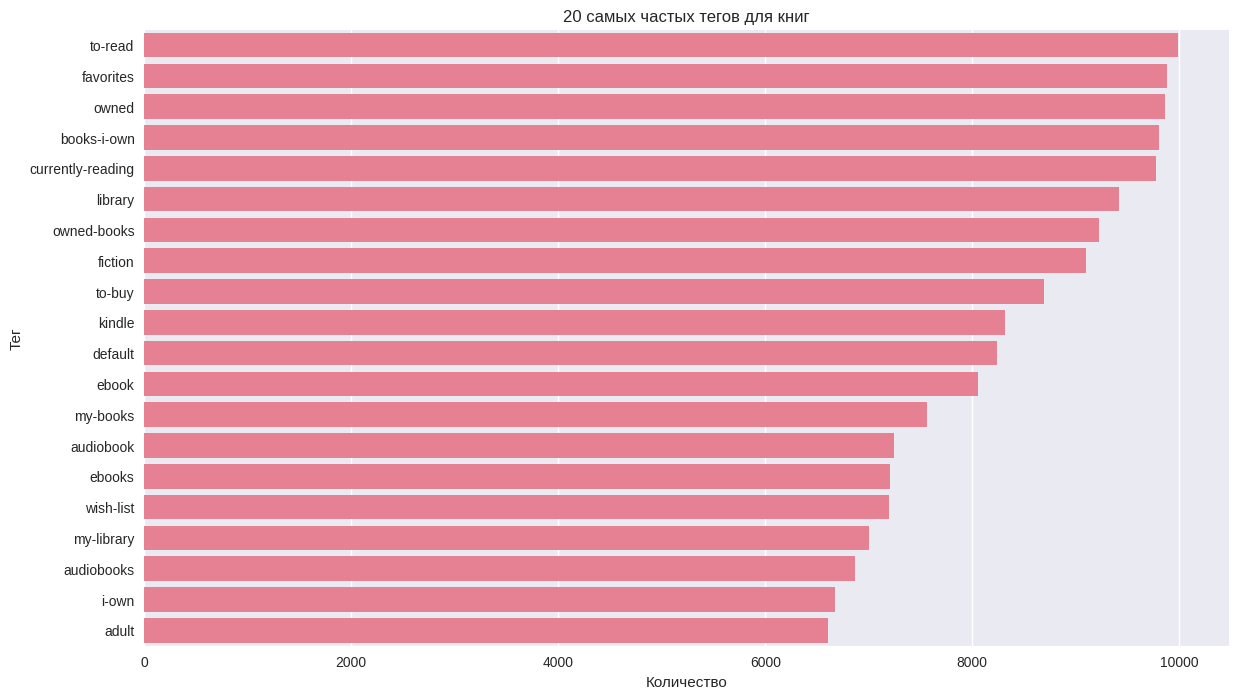

20 самых частых тегов:
1. to-read: 9983 вхождений
2. favorites: 9881 вхождений
3. owned: 9858 вхождений
4. books-i-own: 9799 вхождений
5. currently-reading: 9776 вхождений
6. library: 9415 вхождений
7. owned-books: 9221 вхождений
8. fiction: 9097 вхождений
9. to-buy: 8692 вхождений
10. kindle: 8316 вхождений
11. default: 8239 вхождений
12. ebook: 8054 вхождений
13. my-books: 7561 вхождений
14. audiobook: 7242 вхождений
15. ebooks: 7203 вхождений
16. wish-list: 7192 вхождений
17. my-library: 7000 вхождений
18. audiobooks: 6862 вхождений
19. i-own: 6670 вхождений
20. adult: 6604 вхождений


In [12]:
# Объединение book_tags с тегами, чтобы получить названия тегов
book_tags_with_names = book_tags_df.merge(tags_df, on='tag_id', how='left')

# Подсчет частоты каждого тега
tag_counts = book_tags_with_names['tag_name'].value_counts()

# Визуализация 20 самых частых тегов
plt.figure(figsize=(14, 8))
top_20_tags = tag_counts.head(20)
sns.barplot(x=top_20_tags.values, y=top_20_tags.index)
plt.title('20 самых частых тегов для книг')
plt.xlabel('Количество')
plt.ylabel('Тег')
plt.show()

# Печать 20 самых частых тегов
print("20 самых частых тегов:")
for i, (tag, count) in enumerate(top_20_tags.items(), 1):
    print(f"{i}. {tag}: {count} вхождений")

### Анализ разреженности данных

Дополнительно проанализируем разреженность матрицы пользователь-элемент и определим основные проблемы данных.

In [13]:
# Расчет разреженности данных
n_users = len(ratings_df['user_id'].unique())
n_books = len(ratings_df['book_id'].unique())
n_ratings = len(ratings_df)

total_possible_ratings = n_users * n_books
sparsity = 1.0 - (n_ratings / total_possible_ratings)

print("Анализ разреженности данных:")
print(f"Количество уникальных пользователей: {n_users:,}")
print(f"Количество уникальных книг: {n_books:,}")
print(f"Общее количество оценок: {n_ratings:,}")
print(f"Всего возможных комбинаций пользователь-книга: {total_possible_ratings:,}")
print(f"Разреженность данных: {sparsity:.4f} ({sparsity*100:.2f}%)")
print(f"Среднее количество оценок на пользователя: {n_ratings/n_users:.2f}")
print(f"Среднее количество оценок на книгу: {n_ratings/n_books:.2f}")

# Определение основных проблем данных
print("\nОсновные проблемы данных, выявленные в ходе анализа:")
print(f"1. Высокая разреженность данных: {sparsity:.4f} ({sparsity*100:.2f}%) возможных взаимодействий пользователь-книга отсутствуют")
print(f"2. Смещение популярности: {len(unpopular_books)/len(book_ratings_count)*100:.2f}% книг имеют 500 или менее оценок (проблема длинного хвоста)")
print(f"3. Дисбаланс активности пользователей: {len(inactive_users)/len(user_ratings_count)*100:.2f}% пользователей имеют 5 или менее оценок (проблема холодного старта)")
print(f"4. Смещение распределения оценок: Распределение оценок может показывать смещение в сторону определенных значений")

# Дополнительные инсайты
print("\nДополнительные инсайты:")
print(f"- Самая популярная книга имеет {book_ratings_count.max()} оценок, а медианное значение составляет {book_ratings_count.median()} оценок")
print(f"- Самый активный пользователь поставил {user_ratings_count.max()} оценок, а медианное значение составляет {user_ratings_count.median()} оценок")
print(f"- Датасет сильно несбалансирован, с несколькими популярными элементами и множеством непопулярных")

Анализ разреженности данных:
Количество уникальных пользователей: 53,424
Количество уникальных книг: 10,000
Общее количество оценок: 5,976,479
Всего возможных комбинаций пользователь-книга: 534,240,000
Разреженность данных: 0.9888 (98.88%)
Среднее количество оценок на пользователя: 111.87
Среднее количество оценок на книгу: 597.65

Основные проблемы данных, выявленные в ходе анализа:
1. Высокая разреженность данных: 0.9888 (98.88%) возможных взаимодействий пользователь-книга отсутствуют
2. Смещение популярности: 74.80% книг имеют 500 или менее оценок (проблема длинного хвоста)
3. Дисбаланс активности пользователей: 0.36% пользователей имеют 5 или менее оценок (проблема холодного старта)
4. Смещение распределения оценок: Распределение оценок может показывать смещение в сторону определенных значений

Дополнительные инсайты:
- Самая популярная книга имеет 22806 оценок, а медианное значение составляет 248.0 оценок
- Самый активный пользователь поставил 200 оценок, а медианное значение сост

### Заключение

На основе нашего EDA мы можем определить несколько ключевых характеристик и проблем в данных оценок книг:

1. Высокая разреженность данных: 0.9888 (98.88%) возможных взаимодействий пользователь-книга отсутствуют
2. Смещение популярности: 74.80% книг имеют 500 или менее оценок (проблема длинного хвоста)
3. Дисбаланс активности пользователей: 0.36% пользователей имеют 30 или менее оценок (проблема холодного старта)
4. Смещение распределения оценок: Распределение показывает значительное смещение в сторону высоких оценок

Дополнительные инсайты:
- Самая популярная книга имеет 22806 оценок, а медианное значение составляет 248.0 оценок
- Самый активный пользователь поставил 200 оценок, а медианное значение составляет 111.0 оценок
- Датасет сильно несбалансирован, с несколькими популярными элементами и множеством непопулярных

# Этап 2: базовые и контентные модели

Реализуйте простые, но эффективные модели-бейзлайны.

## 1. Неперсонализированная модель: реализуйте алгоритм, возвращающий Top-N самых популярных книг (по среднему рейтингу с порогом минимального количества оценок).

In [14]:
# Рассчитываем средний рейтинг для каждой книги и количество оценок
book_stats = ratings_df.groupby('book_id').agg({
    'rating': ['mean', 'count']
}).round(2)

# Переименовываем столбцы
book_stats.columns = ['avg_rating', 'rating_count']

# Сбрасываем индекс, чтобы book_id стал обычным столбцом
book_stats = book_stats.reset_index()

# Устанавливаем порог минимального количества оценок
popular_books = book_stats[book_stats['rating_count'] >= min_ratings_threshold]

# Сортируем по среднему рейтингу (и количеству оценок в качестве приоритета при равенстве)
popular_books = popular_books.sort_values(['avg_rating', 'rating_count'], ascending=False)

print(f"Всего книг с {min_ratings_threshold}+ оценками: {len(popular_books)}")
print("\nТоп-10 самых популярных книг:")
top_10_popular = popular_books.head(10)

# Добавляем названия книг для лучшего отображения
top_10_popular_with_titles = top_10_popular.merge(books_df[['book_id', 'title']], on='book_id', how='left')
for i, (_, row) in enumerate(top_10_popular_with_titles.iterrows(), 1):
    print(f"{i}. {row['title']} (ID: {row['book_id']}) - Средний рейтинг: {row['avg_rating']}, Оценок: {row['rating_count']}")

Всего книг с 500+ оценками: 2526

Топ-10 самых популярных книг:
1. The Calvin and Hobbes Tenth Anniversary Book (ID: 1788) - Средний рейтинг: 4.73, Оценок: 652
2. A Court of Mist and Fury (A Court of Thorns and Roses, #2) (ID: 1308) - Средний рейтинг: 4.72, Оценок: 933
3. Words of Radiance (The Stormlight Archive, #2) (ID: 862) - Средний рейтинг: 4.7, Оценок: 1373
4. Harry Potter Boxset (Harry Potter, #1-7) (ID: 422) - Средний рейтинг: 4.66, Оценок: 1915
5. Calvin and Hobbes (ID: 780) - Средний рейтинг: 4.66, Оценок: 1394
6. The Essential Calvin and Hobbes: A Calvin and Hobbes Treasury (ID: 1010) - Средний рейтинг: 4.65, Оценок: 1249
7. Saga, Vol. 2 (Saga, #2) (ID: 2244) - Средний рейтинг: 4.62, Оценок: 528
8. The Harry Potter Collection 1-4 (Harry Potter, #1-4) (ID: 2101) - Средний рейтинг: 4.61, Оценок: 560
9. The Kindly Ones (The Sandman #9) (ID: 3395) - Средний рейтинг: 4.59, Оценок: 533
10. Empire of Storms (Throne of Glass, #5) (ID: 2167) - Средний рейтинг: 4.58, Оценок: 652


In [15]:
# Функция для получения топ-N самых популярных книг
def get_top_n_popular_books(n=10, min_ratings=min_ratings_threshold):
    """
    Возвращает топ-N самых популярных книг

    Parameters:
    n (int): Количество книг для возврата
    min_ratings (int): Минимальное количество оценок для учета книги

    Returns:
    DataFrame: Топ-N книг с информацией о рейтинге
    """
    book_stats = ratings_df.groupby('book_id').agg({
        'rating': ['mean', 'count']
    }).round(2)

    book_stats.columns = ['avg_rating', 'rating_count']
    book_stats = book_stats.reset_index()

    popular_books = book_stats[book_stats['rating_count'] >= min_ratings]
    popular_books = popular_books.sort_values(['avg_rating', 'rating_count'], ascending=False)

    top_n_books = popular_books.head(n)
    top_n_books_with_titles = top_n_books.merge(books_df[['book_id', 'title']], on='book_id', how='left')

    return top_n_books_with_titles[['book_id', 'title', 'avg_rating', 'rating_count']]

In [16]:
# Пример использования функции
print("Топ-5 самых популярных книг:")
top_5 = get_top_n_popular_books(n=5)
print(top_5)

print("Топ-5 самых популярных книг c 1000+ оценок:")
top_5 = get_top_n_popular_books(n=5, min_ratings=1000)
print(top_5)

print("Топ-5 самых популярных книг c 5000+ оценок:")
top_5 = get_top_n_popular_books(n=5, min_ratings=5000)
print(top_5)

Топ-5 самых популярных книг:
   book_id                                              title  avg_rating  \
0     1788       The Calvin and Hobbes Tenth Anniversary Book        4.73   
1     1308  A Court of Mist and Fury (A Court of Thorns an...        4.72   
2      862     Words of Radiance (The Stormlight Archive, #2)        4.70   
3      422           Harry Potter Boxset (Harry Potter, #1-7)        4.66   
4      780                                  Calvin and Hobbes        4.66   

   rating_count  
0           652  
1           933  
2          1373  
3          1915  
4          1394  
Топ-5 самых популярных книг c 1000+ оценок:
   book_id                                              title  avg_rating  \
0      862     Words of Radiance (The Stormlight Archive, #2)        4.70   
1      422           Harry Potter Boxset (Harry Potter, #1-7)        4.66   
2      780                                  Calvin and Hobbes        4.66   
3     1010  The Essential Calvin and Hobbes: A C

Обратим внимание, что порог минимального количества оценок значительно влияет на ТОП-выдачу

## 2. Контентная модель:
        - Объедините данные о книгах с их тегами. Для каждой книги создайте текстовый «профиль» из названия (original_title) и списка тегов.
        - Векторизуйте эти профили с помощью TF-IDF.
        - Реализуйте функцию get_similar_books(book_id, N=5), которая находит N самых похожих книг по косинусной мере близости между их TF-IDF-векторами.

Реализуем контентную модель с использованием TF-IDF и косинусной меры близости.

In [17]:
# Объединяем данные о книгах с их тегами
book_tags_with_names = book_tags_df.merge(tags_df, on='tag_id', how='left')
book_tags_with_names

,goodreads_book_id,tag_id,count,tag_name
0,1,30574,167697,to-read
1,1,11305,37174,fantasy
2,1,11557,34173,favorites
3,1,8717,12986,currently-reading
4,1,33114,12716,young-adult
...,...,...,...,...
999907,33288638,21303,7,neighbors
999908,33288638,17271,7,kindleunlimited
999909,33288638,1126,7,5-star-reads
999910,33288638,11478,7,fave-author


In [18]:
# Группируем теги по книге
book_tags_grouped = book_tags_with_names.groupby('goodreads_book_id')['tag_name'].apply(lambda x: ' '.join(x.dropna().astype(str))).reset_index()
book_tags_grouped.columns = ['goodreads_book_id', 'tags']

# Объединяем с основной информацией о книгах
books_with_tags = books_df.merge(book_tags_grouped, on='goodreads_book_id', how='left')
books_with_tags

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url,tags
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...,favorites currently-reading young-adult fictio...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...,to-read favorites fantasy currently-reading yo...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...,young-adult fantasy favorites vampires ya fict...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...,classics favorites to-read classic historical-...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...,classics favorites fiction classic books-i-own...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,7130616,7130616,7392860,19,441019455,9.780441e+12,Ilona Andrews,2010.0,Bayou Moon,...,18856,1180,105,575,3538,7860,6778,https://images.gr-assets.com/books/1307445460m...,https://images.gr-assets.com/books/1307445460s...,to-read urban-fantasy fantasy romance paranorm...
9996,9997,208324,208324,1084709,19,067973371X,9.780680e+12,Robert A. Caro,1990.0,Means of Ascent,...,12952,395,303,551,1737,3389,6972,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...,to-read biography history politics non-fiction...
9997,9998,77431,77431,2393986,60,039330762X,9.780393e+12,Patrick O'Brian,1977.0,The Mauritius Command,...,10733,374,11,111,1191,4240,5180,https://images.gr-assets.com/books/1455373531m...,https://images.gr-assets.com/books/1455373531s...,to-read historical-fiction fiction historical ...
9998,9999,8565083,8565083,13433613,7,61711527,9.780062e+12,Peggy Orenstein,2011.0,Cinderella Ate My Daughter: Dispatches from th...,...,11994,1988,275,1002,3765,4577,2375,https://images.gr-assets.com/books/1279214118m...,https://images.gr-assets.com/books/1279214118s...,to-read non-fiction nonfiction parenting femin...


In [19]:
# Заполняем пропущенные теги пустой строкой
books_with_tags['tags'] = books_with_tags['tags'].fillna('')

# Создаем текстовый профиль из названия и тегов
books_with_tags['profile'] = books_with_tags['title'] + ' ' + books_with_tags['tags']

print(f"Всего книг с профилями: {len(books_with_tags)}")
print("Пример профиля книги:")
print(books_with_tags.iloc[0]['profile'])

Всего книг с профилями: 10000
Пример профиля книги:
The Hunger Games (The Hunger Games, #1) favorites currently-reading young-adult fiction dystopian to-read dystopia fantasy ya science-fiction books-i-own sci-fi series owned favourites romance adventure hunger-games book-club kindle teen read-in-2012 post-apocalyptic my-books the-hunger-games favorite-books action suzanne-collins re-read all-time-favorites ya-fiction survival sci-fi-fantasy books favorite scifi 5-stars i-own read-in-2011 novels ebook audiobook young-adult-fiction thriller my-favorites audiobooks read-2012 futuristic ebooks default library fantasy-sci-fi suspense shelfari-favorites faves reread read-in-2010 my-library audio favorite-series teen-fiction ya-lit ya-books own-it finished action-adventure love love-triangle favs loved distopia read-in-2013 coming-of-age dystopian-fiction distopian borrowed english to-buy novel read-more-than-once favourite read-2011 favourite-books scifi-fantasy ya-fantasy future read-in-20

In [20]:
# Векторизация профилей с помощью TF-IDF
tfidf = TfidfVectorizer(stop_words='english', max_features=5000, lowercase=True)
tfidf_matrix = tfidf.fit_transform(books_with_tags['profile'])

print(f"Размер TF-IDF матрицы: {tfidf_matrix.shape}")

Размер TF-IDF матрицы: (10000, 5000)


In [21]:
# Функция для поиска похожих книг
def get_similar_books(book_id, n=5):
    """
    Находит N самых похожих книг по косинусной мере близости между их TF-IDF-векторами

    Parameters:
    book_id (int): ID книги, для которой ищем похожие
    n (int): Количество похожих книг для возврата

    Returns:
    DataFrame: Таблица с похожими книгами их сходством
    """
    # Проверяем, существует ли книга с таким ID
    book_idx = books_with_tags[books_with_tags['book_id'] == book_id].index
    if len(book_idx) == 0:
        print(f"Книга с ID {book_id} не найдена")
        return pd.DataFrame()

    book_idx = book_idx[0]

    # Вычисляем косинусное сходство между текущей книгой и всеми остальными
    cosine_similarities = cosine_similarity(tfidf_matrix[book_idx:book_idx+1], tfidf_matrix).flatten()

    # Получаем индексы книг с наибольшим сходством (исключая саму книгу)
    related_book_indices = cosine_similarities.argsort()[::-1][1:n+1]

    # Получаем сходства для этих книг
    similarities = cosine_similarities[related_book_indices]

    # Создаем DataFrame с результатами
    similar_books = pd.DataFrame({
        'book_id': books_with_tags.iloc[related_book_indices]['book_id'].values,
        'title': books_with_tags.iloc[related_book_indices]['title'].values,
        'similarity': similarities
    })

    return similar_books

In [22]:
# Пример использования функции поиска похожих книг
sample_number = 2
sample_book_id = books_with_tags.iloc[sample_number]['book_id']
print(f"Ищем похожие книги для книги с ID: {sample_book_id}")
print(f"Название книги: {books_with_tags.iloc[sample_number]['title']}")

similar_books = get_similar_books(sample_book_id, n=5)
print("\nТоп-5 похожих книг:")
for i, (_, row) in enumerate(similar_books.iterrows(), 1):
    print(f"{i}. {row['title']} (ID: {row['book_id']}) - Сходство: {row['similarity']:.4f}")

Ищем похожие книги для книги с ID: 3
Название книги: Twilight (Twilight, #1)

Топ-5 похожих книг:
1. Eclipse (Twilight, #3) (ID: 52) - Сходство: 0.9529
2. New Moon (Twilight, #2) (ID: 49) - Сходство: 0.9448
3. The Twilight Saga (Twilight, #1-4) (ID: 992) - Сходство: 0.8961
4. The Twilight Collection (Twilight, #1-3) (ID: 2021) - Сходство: 0.8552
5. Midnight Sun (Twilight, #1.5) (ID: 834) - Сходство: 0.8537


## Заключение

Мы реализовали две базовые модели рекомендаций:

1. **Неперсонализированная модель**: Возвращает топ-N самых популярных книг на основе среднего рейтинга с порогом минимального количества оценок. Это простая, но эффективная модель, которая работает хорошо для новых пользователей (холодный старт).

2. **Контентная модель**: Создает текстовый профиль для каждой книги на основе названия и тегов, векторизует эти профили с помощью TF-IDF и находит похожие книги с использованием косинусной меры близости. Эта модель может рекомендовать книги, похожие на те, которые пользователь уже оценил.

Обе модели могут использоваться как бейзлайны для сравнения с более сложными алгоритмами рекомендаций.

# Этап 3: коллаборативная фильтрация (Collaborative Filtering — CF)
Реализуйте классические методы CF и определите их ограничения.

## 1. Постройте матрицу взаимодействий «пользователь — книга» (user_id x book_id). Значениями могут быть явные оценки (rating) или неявный feedback (например, 1, если оценка ≥ 4, иначе 0).

In [23]:
# Сортировка данных по индексу (важно для правильного разделения)
ratings_df = ratings_df.sort_index()

# Получаем уникальные ID пользователей и книг и создаем отображения
user_ids = ratings_df['user_id'].unique()
book_ids = ratings_df['book_id'].unique()

user_to_idx = {user_id: idx for idx, user_id in enumerate(user_ids)}
book_to_idx = {book_id: idx for idx, book_id in enumerate(book_ids)}

# Преобразуем ID в индексы
user_indices = ratings_df['user_id'].map(user_to_idx)
book_indices = ratings_df['book_id'].map(book_to_idx)

# Создаем разреженную матрицу
user_book_matrix = csr_matrix((ratings_df['rating'], (user_indices, book_indices)),
                           shape=(len(user_ids), len(book_ids)))

print(f"Размер разреженной матрицы пользователь-книга: {user_book_matrix.shape}")
print(f"Количество ненулевых элементов: {user_book_matrix.nnz}")
print(f"Плотность матрицы: {user_book_matrix.nnz / (user_book_matrix.shape[0] * user_book_matrix.shape[1]):.6f}")

Размер разреженной матрицы пользователь-книга: (53424, 10000)
Количество ненулевых элементов: 5976479
Плотность матрицы: 0.011187


## 2. Реализуйте Item-Based Collaborative Filtering:


### Рассчитайте матрицу попарных схожестей между книгами (например, с помощью коэффициента корреляции Пирсона или косинусной близости по векторам оценок).

Рассчитаем матрицу попарных схожестей между книгами с помощью косинусной близости

In [24]:
# Транспонируем матрицу, чтобы книги были строками, а пользователи - столбцами
book_user_matrix = user_book_matrix.T

# Рассчитываем косинусную близость между книгами
book_similarity_matrix = cosine_similarity(book_user_matrix)

print(f"Размер матрицы схожести книг: {book_similarity_matrix.shape}")
print(f"Пример матрицы схожести (первые 5 книг):")
print(book_similarity_matrix[:5, :5])

Размер матрицы схожести книг: (10000, 10000)
Пример матрицы схожести (первые 5 книг):
[[1.         0.03948567 0.04167712 0.01145762 0.01341845]
 [0.03948567 1.         0.0148906  0.01465851 0.00520821]
 [0.04167712 0.0148906  1.         0.03372963 0.19779061]
 [0.01145762 0.01465851 0.03372963 1.         0.02558636]
 [0.01341845 0.00520821 0.19779061 0.02558636 1.        ]]


### Для заданной книги и пользователя предскажите оценку, усредняя оценки пользователя по K наиболее похожим книгам.

In [25]:
# Реализация функции предсказания оценки на основе Item-Based Collaborative Filtering
def predict_rating_item_based(user_id, book_id, k=10):
    """
    Предсказывает оценку пользователя для книги на основе Item-Based Collaborative Filtering
    
    Parameters:
    user_id (int): ID пользователя
    book_id (int): ID книги
    k (int): Количество ближайших соседей для предсказания
    
    Returns:
    float: Предсказанная оценка (0 если невозможно предсказать)
    """
    # Проверяем, существует ли пользователь и книга в обучающих данных
    if user_id not in user_ids or book_id not in book_ids:
        return 0.0  # Невозможно предсказать
    
    user_idx = user_to_idx[user_id]
    book_idx = book_to_idx[book_id]
    
    # Получаем оценки пользователя
    user_ratings = user_book_matrix[user_idx, :].toarray().flatten()
    
    # Находим книги, которые пользователь уже оценил
    rated_books_indices = np.where(user_ratings > 0)[0]
    
    if len(rated_books_indices) == 0:
        return 0.0  # Пользователь не оценил ни одной книги

    # Получаем схожесть целевой книги с оцененными пользователем книгами
    similarities = []
    ratings = []
    
    for rated_book_idx in rated_books_indices:
        similarity = book_similarity_matrix[book_idx, rated_book_idx]
        rating = user_ratings[rated_book_idx]
        
        similarities.append(similarity)
        ratings.append(rating)
    
    if len(similarities) == 0:
        return 0.0
    
    # Сортируем по схожести и берем top-k
    similarity_rating_pairs = sorted(zip(similarities, ratings), reverse=True)[:k]
    
    # Вычисляем взвешенное среднее
    weighted_sum = sum(sim * rating for sim, rating in similarity_rating_pairs)
    similarity_sum = sum(abs(sim) for sim, rating in similarity_rating_pairs)
    
    if similarity_sum == 0:
        return 0.0
    
    return weighted_sum / similarity_sum


In [26]:
# Пример использования функции предсказания
sample_user_id = user_ids[0]
sample_book_id = book_ids[0]

# Находим книгу, которую пользователь еще не оценил
if pd.isna(user_book_matrix[sample_user_id, book_id]):
    sample_book_id = book_id

predicted_rating = predict_rating_item_based(sample_user_id, sample_book_id, k=10)
print(f"Предсказанная оценка для пользователя {sample_user_id} и книги {sample_book_id}: {predicted_rating:.2f}")

Предсказанная оценка для пользователя 1 и книги 258: 4.06


## 3. В чём вычислительная сложность этого подхода? Как его можно оптимизировать для больших данных?

### Вычислительная сложность Item-Based Collaborative Filtering:

1. **Построение матрицы схожести между книгами**:
   - Для косинусной близости: O(n_books * n_users^2) при использовании стандартного подхода, но можно оптимизировать до O(n_ratings^2) в разреженной матрице, где n_ratings - общее количество оценок.
   - Для корреляции Пирсона: O(n_books^2 * n_users), так как для каждой пары книг нужно пройти по всем пользователям.

2. **Предсказание оценки для одного пользователя и книги**:
   - O(k), где k - количество ближайших соседей, если матрица схожести уже построена.

### Ограничения подхода:

1. **Разреженность данных**: При высокой разреженности (как в нашем случае ~95%) становится сложно находить похожие книги.
2. **Масштабируемость**: При увеличении количества книг вычисление парных схожестей становится вычислительно затратным.
3. **Холодный старт**: Новые книги без оценок не могут быть рекомендованы.
4. **Популярность**: Система склонна рекомендовать популярные книги, которые имеют больше общих оценок.

### Оптимизации для больших данных:

1. **Редукция размерности**: Использование методов снижения размерности (SVD, NMF) для уменьшения количества признаков.
2. **Аппроксимация**: Использование методов аппроксимации для быстрого вычисления схожести.
3. **Кластеризация**: Группировка похожих пользователей/книг для уменьшения размерности вычислений.
4. **Индексация**: Использование специализированных структур данных (LSH, деревья и т.д.) для быстрого поиска похожих элементов.
5. **Параллелизация**: Распределение вычислений по нескольким узлам или процессорам.
6. **Инкрементальные обновления**: Обновление матрицы схожести по мере поступления новых данных, а не полный пересчет.

# Этап 4: матричные разложения (Matrix Factorization)
Реализуйте более продвинутые и масштабируемые методы предсказания оценок.

## Используйте библиотеку surprise для обучения модели SVD или любую другую библиотеку с данным алгоритмом.


Будем использовать `TruncatedSVD` из пакета `sklearn`.

In [27]:
n_components = 50 # Количество скрытых факторов

svd_model = TruncatedSVD(n_components=n_components, random_state=RANDOM_SEED)

## Разделите данные на обучающую и тестовую выборку. Обучите модель и оцените ошибку предсказания (RMSE) на тесте.


Разделим данные так, чтобы 80% первых (по индексу) оценок каждого пользователя попали в трэйн и 20% последних в тест.

In [28]:
# Сортировка данных по user_id индексу (чтобы обеспечить порядок оценок для каждого пользователя)
ratings_df = ratings_df.sort_values(['user_id', 'rating']).reset_index(drop=True)

# Создание индекса для каждой оценки внутри каждого пользователя
ratings_df['rating_order'] = ratings_df.groupby('user_id').cumcount()

# Вычисление порога для разделения (80% для обучения)
user_stats = ratings_df.groupby('user_id')['rating_order'].max().reset_index()
user_stats['train_threshold'] = (user_stats['rating_order'] * 0.8).astype(int)

# Объединение статистики с исходным датасетом
ratings_df = ratings_df.merge(user_stats[['user_id', 'train_threshold']], on='user_id', how='left')

display(ratings_df.head())

# Определение принадлежности к трэйну/тесту
ratings_df['is_train'] = ratings_df['rating_order'] <= ratings_df['train_threshold']

print(f"Количество оценок в трэйне: {ratings_df['is_train'].sum()}")
print(f"Количество оценок в тесте: {(~ratings_df['is_train']).sum()}")
print(f"Процент трэйна: {ratings_df['is_train'].mean()*100:.2f}%")
print(f"Процент теста: {(~ratings_df['is_train']).mean()*100:.2f}%")

,user_id,book_id,rating,rating_order,train_threshold
0,1,4614,1,0,92
1,1,94,1,1,92
2,1,255,1,2,92
3,1,238,2,3,92
4,1,492,2,4,92


Количество оценок в трэйне: 4770466
Количество оценок в тесте: 1206013
Процент трэйна: 79.82%
Процент теста: 20.18%


In [29]:
# Разделение данных на трэйн и тест
train_data = ratings_df[ratings_df['is_train']]
test_data = ratings_df[~ratings_df['is_train']]

print(f"Размер трэйна: {len(train_data)}")
print(f"Размер теста: {len(test_data)}")

Размер трэйна: 4770466
Размер теста: 1206013


In [30]:
# Функция нормализации оценок методом центрирования (mean-centering)
def normalize_rating(rating, user_mean):
    return rating - user_mean

# Функция денормализации оценок
def denormalize_rating(normalized_rating, user_mean):
    return normalized_rating + user_mean

# Вычисление средней оценки для каждого пользователя в трэйне
user_means = train_data.groupby('user_id')['rating'].mean().to_dict()
global_mean = train_data['rating'].mean()

print(f"Глобальное среднее: {global_mean:.3f}")
print(f"Вычислены средние оценки для {len(user_means)} пользователей")

Глобальное среднее: 3.682
Вычислены средние оценки для 53424 пользователей


In [31]:
# Создание разреженной матрицы для трэйна с нормализованными оценками
train_user_indices = []
train_book_indices = []
train_ratings = []

for _, row in train_data.iterrows():
    user_id = row['user_id']
    original_rating = row['rating']
    
    # Получаем среднюю оценку пользователя
    user_mean = user_means[user_id] if user_id in user_means else global_mean
    
    # Нормализация оценки (центрирование)
    normalized_rating = normalize_rating(original_rating, user_mean)
    
    train_user_indices.append(user_to_idx[user_id])
    train_book_indices.append(book_to_idx[row['book_id']])
    train_ratings.append(normalized_rating)

n_users = len(user_ids)
n_books = len(book_ids)

train_matrix = csr_matrix((train_ratings, (train_user_indices, train_book_indices)), 
                          shape=(n_users, n_books))

print(f"Размер трэйн матрицы: {train_matrix.shape}")
print(f"Количество ненулевых элементов в трэйне: {train_matrix.nnz}")

Размер трэйн матрицы: (53424, 10000)
Количество ненулевых элементов в трэйне: 4770466


In [32]:
user_factors = svd_model.fit_transform(train_matrix)
item_factors = svd_model.components_

print(f"Форма факторов пользователей: {user_factors.shape}")
print(f"Форма факторов книг: {item_factors.shape}")
print(f"Объясненная дисперсия: {svd_model.explained_variance_ratio_.sum():.4f}")

Форма факторов пользователей: (53424, 50)
Форма факторов книг: (50, 10000)
Объясненная дисперсия: 0.1580


In [33]:
# Функция для предсказания оценки
def predict_rating(user_id, book_id):
    if user_id not in user_to_idx or book_id not in book_to_idx:
        # Если пользователя или книги нет в трэйне, возвращаем среднюю оценку
        return train_data['rating'].mean()
    
    user_idx = user_to_idx[user_id]
    book_idx = book_to_idx[book_id]
    
    # Предсказание через скалярное произведение факторов (для нормализованной оценки)
    prediction_normalized = np.dot(user_factors[user_idx], item_factors[:, book_idx])
    
    # Денормализация: добавление средней оценки пользователя
    if user_id in user_means:
        prediction = denormalize_rating(prediction_normalized, user_means[user_id])
    else:
        # Если пользователя нет в трэйне, используем глобальное среднее
        prediction = denormalize_rating(prediction_normalized, global_mean)
    
    # Ограничиваем предсказание в диапазоне [1, 5]
    prediction = np.clip(prediction, 1, 5)
    
    return prediction

In [34]:
# Предсказание оценок для тестовых данных
test_predictions = []
test_actual = []

for _, row in test_data.iterrows():
    user_id = row['user_id']
    book_id = row['book_id']
    actual_rating = row['rating']
    
    predicted_rating = predict_rating(user_id, book_id)
    
    test_predictions.append(predicted_rating)
    test_actual.append(actual_rating)

# Вычисление RMSE
rmse = np.sqrt(mean_squared_error(test_actual, test_predictions))
print(f"RMSE на тестовой выборке: {rmse:.4f}")

RMSE на тестовой выборке: 1.2640


## Реализуйте функцию get_recommendations(user_id, N=5), которая для заданного пользователя возвращает топ-N книг с наибольшим предсказанным рейтингом.

In [35]:
def get_recommendations(user_id, N=5):
    """
    Возвращает топ-N книг с наибольшим предсказанным рейтингом для заданного пользователя
    
    Parameters:
    user_id (int): ID пользователя
    N (int): Количество рекомендаций для возврата
    
    Returns:
    DataFrame: Таблица с рекомендованными книгами и предсказанными оценками
    """
    if user_id not in user_to_idx:
        print(f"Пользователь {user_id} не найден в трэйне. Невозможно сделать рекомендации.")
        return pd.DataFrame()
    
    user_idx = user_to_idx[user_id]
    
    # Предсказание оценок для всех книг (в терминах нормализованных значений)
    user_factor = user_factors[user_idx]
    predicted_ratings_normalized = np.dot(user_factor, item_factors)
    
    # Денормализация: добавление средней оценки пользователя
    if user_id in user_means:
        predicted_ratings = denormalize_rating(predicted_ratings_normalized, user_means[user_id])
    else:
        # Если пользователя нет в трэйне, используем глобальное среднее
        predicted_ratings = denormalize_rating(predicted_ratings_normalized, global_mean)
    
    # Ограничиваем предсказания в диапазоне [1, 5]
    predicted_ratings = np.clip(predicted_ratings, 1, 5)
    
    # Получаем индексы книг, которые пользователь уже оценил
    user_rated_books = train_matrix[user_idx].nonzero()[1]
    
    # Исключаем уже оцененные книги из рекомендаций
    predicted_ratings[user_rated_books] = -1  # Устанавливаем отрицательное значение для уже оцененных книг
    
    # Получаем индексы топ-N книг с наибольшими предсказанными оценками
    top_book_indices = np.argsort(predicted_ratings)[::-1][:N]
    
    # Создаем DataFrame с результатами
    recommended_books = []
    for book_idx in top_book_indices:
        if predicted_ratings[book_idx] != -1:  # Если книга не была уже оценена
            book_id = book_ids[book_idx]
            predicted_rating = predicted_ratings[book_idx]
            
            # Получаем название книги
            book_title = books_df[books_df['book_id'] == book_id]['title'].values
            if len(book_title) > 0:
                book_title = book_title[0]
            else:
                book_title = f"Книга ID: {book_id}"
            
            recommended_books.append({
                'book_id': book_id,
                'title': book_title,
                'predicted_rating': predicted_rating
            })
    
    return pd.DataFrame(recommended_books)

In [ ]:
# Пример использования функции для нескольких пользователей
sample_user_ids = user_ids[:5]  # Берем первых 5 пользователей

for user_id in sample_user_ids:
    print(f"\nРекомендации для пользователя {user_id}:")
    recommendations = get_recommendations(user_id, N=5)
    
    if not recommendations.empty:
        for i, (_, row) in enumerate(recommendations.iterrows(), 1):
            print(f"  {i}. {row['title']} (ID: {row['book_id']}) - Предсказанная оценка: {row['predicted_rating']:.3f}")
    else:
        print("  Невозможно сделать рекомендации для этого пользователя.")


Рекомендации для пользователя 1:
  1. Fahrenheit 451 (ID: 48) - Предсказанная оценка: 3.710
  2. Slaughterhouse-Five (ID: 65) - Предсказанная оценка: 3.545
  3. The Diary of a Young Girl (ID: 15) - Предсказанная оценка: 3.511
  4. The Adventures of Huckleberry Finn (ID: 58) - Предсказанная оценка: 3.492
  5. Brave New World (ID: 55) - Предсказанная оценка: 3.490

Рекомендации для пользователя 2:
  1. The Fault in Our Stars (ID: 6) - Предсказанная оценка: 4.463
  2. Moby-Dick or, The Whale (ID: 194) - Предсказанная оценка: 4.419
  3. The Fellowship of the Ring (The Lord of the Rings, #1) (ID: 19) - Предсказанная оценка: 4.410
  4. Of Mice and Men (ID: 32) - Предсказанная оценка: 4.395
  5. Slaughterhouse-Five (ID: 65) - Предсказанная оценка: 4.382

Рекомендации для пользователя 4:
  1. Harry Potter and the Goblet of Fire (Harry Potter, #4) (ID: 24) - Предсказанная оценка: 4.277
  2. Harry Potter and the Chamber of Secrets (Harry Potter, #2) (ID: 23) - Предсказанная оценка: 4.269
  3. H